In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from phd.feature_search.core.idbd import IDBD
from phd.feature_search.core.models import MultipleLinear

%matplotlib inline

In [146]:
def run_ensemble_experiment(
    train_steps = 3000,
    meta_lr = 0.005,
    init_lr = 0.001,
    n_inputs = 1,
    n_distractors = 99,
    member_dim = 20,
    n_models = 10,
    noise_strength = 0.0,
    return_model_weights = False,
    return_real_feature_weights = False,
    real_features_first = False,
    device = torch.device('cpu'),
    seed = 20250813,
):
    torch.manual_seed(seed)
    data_generator = torch.Generator(device=device).manual_seed(seed)

    true_weights = torch.randn(1, n_inputs, device=device)
    model = MultipleLinear(member_dim + 1, 1, n_models, bias=False).to(device)
    torch.nn.init.zeros_(model.weight)

    # Sample member indices for each model, dim: (n_models, member_dim)
    # Index 0 is always the real input
    if real_features_first:
        assert n_inputs == 1, "Real features first is only supported for single input!"
        member_indices = torch.stack([
            torch.cat([
                torch.tensor([0]),
                torch.randperm(n_inputs + n_distractors - 1)[:member_dim - 1] + 1,
            ])
            for _ in range(n_models)
        ], dim=0).to(device)
    else:
        member_indices = torch.stack([
            torch.randperm(n_inputs + n_distractors)[:member_dim]
            for _ in range(n_models)
        ], dim=0).to(device)
        
    real_feature_indices = []
    for i in range(n_inputs):
        real_feature_indices.append(torch.where(member_indices == i))
    
    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)

    losses = []
    model_weights = []
    real_feature_weights = [[] for _ in range(n_inputs)] # Each element is a list of weights over time for that index feature

    for i in range(train_steps):
        true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
        noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
        
        # Get the features for each model and add bias
        features = noisy_X[member_indices]
        features = torch.cat([
            features, torch.ones(n_models, 1, device=device)], dim=1)
        
        y_preds = model(features).squeeze(1)
        target = true_weights @ true_X[:n_inputs]
        individual_losses = (target.expand(n_models) - y_preds).pow(2)
        
        with torch.no_grad():
            mean_pred = y_preds.mean()
            pred_loss = (target - mean_pred).pow(2)
            losses.append(pred_loss.item())
            if return_model_weights:
                model_weights.append(model.weight.detach().cpu().clone())
            if return_real_feature_weights:
                cpu_weights = model.weight.squeeze(1).detach().cpu().clone()
                for i in range(n_inputs):
                    real_feature_weights[i].append(cpu_weights[real_feature_indices[i]])

        optimizer.zero_grad()
        individual_losses.sum().backward(retain_graph=True)
        optimizer.step(predictions=y_preds)

    results = {
        'losses': losses,
        'model': model,
        'member_indices': member_indices,
        'true_weights': true_weights,
    }
    if return_model_weights:
        results['model_weights'] = torch.stack(model_weights)
    if return_real_feature_weights:
        real_feature_weights = [torch.stack(weights) for weights in real_feature_weights]
        results['real_feature_weights'] = real_feature_weights

    return results

## Initial step-size search

Average loss for init_lr=0.062500: 2.516695
Average loss for init_lr=0.031250: 2.516678
Average loss for init_lr=0.015625: 2.516645
Average loss for init_lr=0.007812: 2.424600
Average loss for init_lr=0.003906: 2.331577
Average loss for init_lr=0.001953: 2.286356
Average loss for init_lr=0.000977: 2.274341
Average loss for init_lr=0.000488: 2.288552
Average loss for init_lr=0.000244: 2.325645
Average loss for init_lr=0.000122: 2.385509
Average loss for init_lr=0.000061: 2.464150


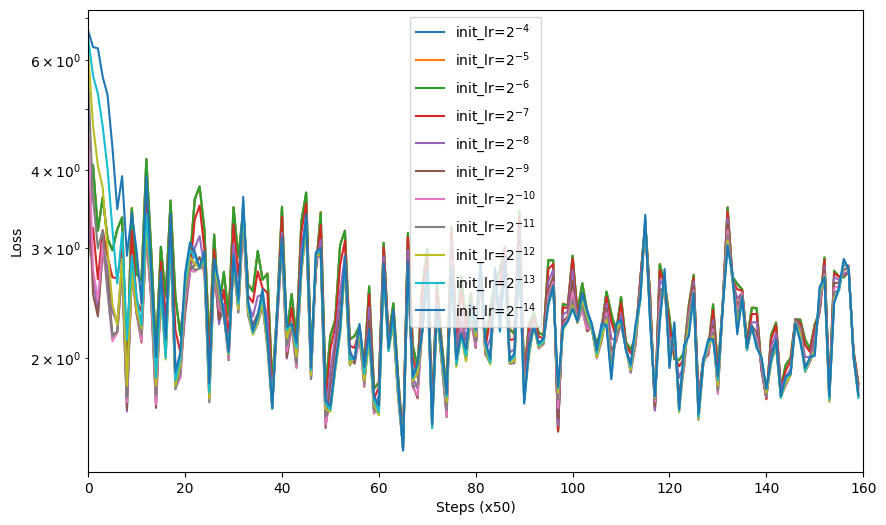

In [194]:
init_lrs = [2**(-i) for i in range(4, 15)]
plt.figure(figsize=(10, 6))

train_steps = 8000
x_bin_size = 50

for init_lr in init_lrs:
    results = run_ensemble_experiment(
        train_steps = train_steps,
        init_lr = init_lr,
        n_inputs = 10,
        n_distractors = 90,
        member_dim = 32,
        n_models = 20,
        return_model_weights = False,
        real_features_first = False,
        noise_strength = 1.0,
    )
    losses = np.array(results['losses']).reshape(-1, x_bin_size).mean(1)
    plt.plot(
        losses,
        label = f'init_lr=$2^{{-{int(np.log2(1/init_lr))}}}$',
    )
    print(f"Average loss for init_lr={init_lr:.6f}: {losses.mean():.6f}")

plt.xlabel(f'Steps (x{x_bin_size})')
plt.xlim(0, train_steps/x_bin_size)
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

## Ensemble gradient stabalization for single weight


Average distance from true weight per step:
Member count 1: 0.007017
Member count 2: 0.007425
Member count 4: 0.007949
Member count 8: 0.008496
Member count 16: 0.007843
Member count 32: 0.008188
Member count 64: 0.008431


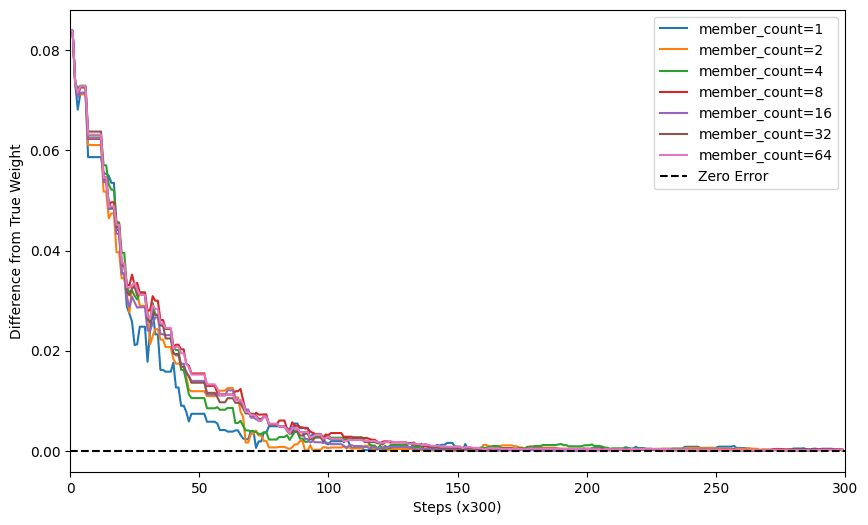

In [173]:
member_counts = [1, 2, 4, 8, 16, 32, 64]

# Store values for both plots
weight_estimates = {}
weight_differences = {}
avg_distances = {}

x_bin_size = 1
train_steps = 300

for member_count in member_counts:
    results = run_ensemble_experiment(
        train_steps = train_steps,
        init_lr = 2**-4,
        n_models = member_count,
        return_model_weights = True,
        real_features_first = True,
    )
    model_weights = results['model_weights']
    real_feature_values = model_weights[:, :, 0, 0]
    real_feature_value_means = real_feature_values.mean(1).numpy()
    real_weight = results['true_weights'].item()
    
    # Store mean weights and differences from true weight
    abs_weight_differences = np.abs(real_feature_value_means - real_weight)
    weight_differences[member_count] = abs_weight_differences.reshape(-1, x_bin_size).mean(1)
    weight_estimates[member_count] = real_feature_value_means.reshape(-1, x_bin_size).mean(1)
    
    # Calculate average distance from true weight
    avg_distances[member_count] = abs_weight_differences.mean()

# # Plot weight estimates
# plt.figure(figsize=(10, 6))
# for member_count in member_counts:
#     plt.plot(weight_estimates[member_count], label=f'member_count={member_count}')
# plt.axhline(y=real_weight, color='black', linestyle='--', label='True Weight')
# plt.xlabel('Steps' + f' (x{train_steps})' if train_steps > 1 else '')
# plt.xlim(0, train_steps)
# plt.ylabel('Feature Weight Mean')
# plt.legend()

# Plot differences from true weight
plt.figure(figsize=(10, 6))
for member_count in member_counts:
    plt.plot(weight_differences[member_count], label=f'member_count={member_count}')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Error')
plt.xlim(0, train_steps)
plt.xlabel('Steps' + f' (x{train_steps})' if train_steps > 1 else '')
plt.ylabel('Difference from True Weight')
plt.legend()

# Print average distances
print("\nAverage distance from true weight per step:")
for member_count in member_counts:
    print(f"Member count {member_count}: {avg_distances[member_count]:.6f}")

In [ ]:
# TODO: Plot the variance of weight estimates with each member count across different runs

## Ensemble gradient stabalization for multiple weights

In [ ]:
member_counts = [16]

# Store values for both plots
weight_estimates = {}
weight_differences = {}
avg_distances = {}

x_bin_size = 1
train_steps = 300
n_inputs = 10

for member_count in member_counts:
    results = run_ensemble_experiment(
        train_steps = train_steps,
        n_inputs = n_inputs,
        n_distractors = 90,
        member_dim = 32,
        init_lr = 2**-4,
        n_models = member_count,
        return_real_feature_weights = True,
    )
    real_feature_weights = results['real_feature_weights']
    real_feature_weight_means = torch.stack([ws.mean(dim=1) for ws in real_feature_weights], dim=1) # dim: (train_steps, n_inputs)


Average distance from true weight per step:
Member count 4: nan
Member count 8: 0.057811
Member count 16: 0.063752
Member count 32: 0.057968
Member count 64: 0.057406
Member count 128: 0.058876
Member count 256: 0.059295


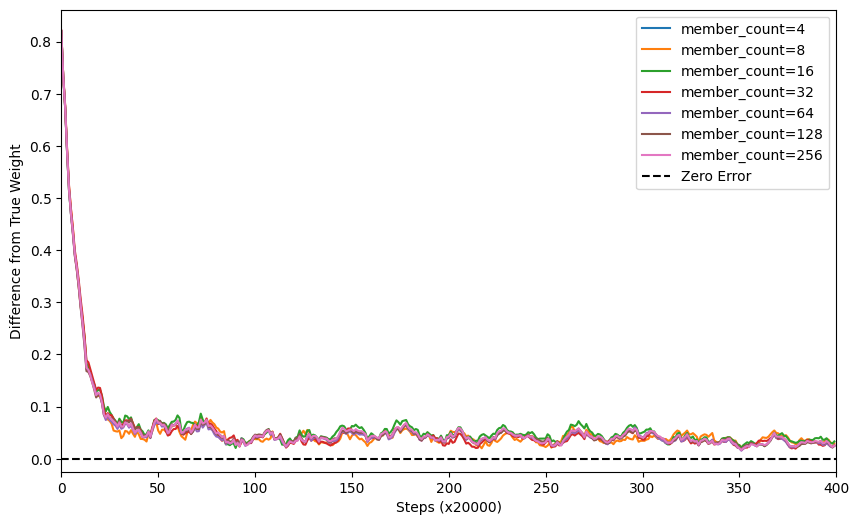

In [ ]:
member_counts = [4, 8, 16, 32, 64, 128, 256]

# Store values for both plots
weight_estimates = {}
weight_differences = {}
avg_distances = {}

x_bin_size = 50
train_steps = 20_000
n_inputs = 10

for member_count in member_counts:
    results = run_ensemble_experiment(
        train_steps = train_steps,
        n_inputs = n_inputs,
        n_distractors = 90,
        member_dim = 32,
        init_lr = 2**-8,
        n_models = member_count,
        return_real_feature_weights = True,
    )
    real_feature_weights = results['real_feature_weights']
    real_feature_weight_means = torch.stack([ws.mean(dim=1) for ws in real_feature_weights], dim=1)
    real_feature_weight_means = real_feature_weight_means.numpy() # dim: (train_steps, n_inputs)
    real_weights = results['true_weights'].squeeze(0).detach().cpu().numpy() # dim: (n_inputs)
    
    # Store mean weights and differences from true weight
    abs_weight_differences = np.abs(real_feature_weight_means - real_weights[None, :])
    weight_differences[member_count] = abs_weight_differences.reshape(-1, x_bin_size, n_inputs).mean(1).mean(1)
    weight_estimates[member_count] = real_feature_weight_means.reshape(-1, x_bin_size, n_inputs).mean(1)
    
    # Calculate average distance from true weight
    avg_distances[member_count] = abs_weight_differences.mean(0)

# # Plot weight estimates
# plt.figure(figsize=(10, 6))
# for member_count in member_counts:
#     plt.plot(weight_estimates[member_count], label=f'member_count={member_count}')
# plt.axhline(y=real_weight, color='black', linestyle='--', label='True Weight')
# plt.xlabel('Steps' + f' (x{train_steps})' if train_steps > 1 else '')
# plt.xlim(0, train_steps)
# plt.ylabel('Feature Weight Mean')
# plt.legend()

# Plot differences from true weight
plt.figure(figsize=(10, 6))
for member_count in member_counts:
    plt.plot(weight_differences[member_count], label=f'member_count={member_count}')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Error')
plt.xlim(0, train_steps // x_bin_size)
plt.xlabel('Steps' + f' (x{x_bin_size})' if train_steps > 1 else '')
plt.ylabel('Difference from True Weight')
plt.legend()

# Print average distances
print("\nAverage distance from true weight per step:")
for member_count in member_counts:
    print(f"Member count {member_count}: {avg_distances[member_count].mean():.6f}")

## Variance of trajectory over multiple runs


Statistics for distance from true weight per step:
Member count 1:
  Mean ± Std: 0.061297 ± 0.014398
  Variance: 0.000207
Member count 64:
  Mean ± Std: 0.147222 ± 0.028809
  Variance: 0.000830


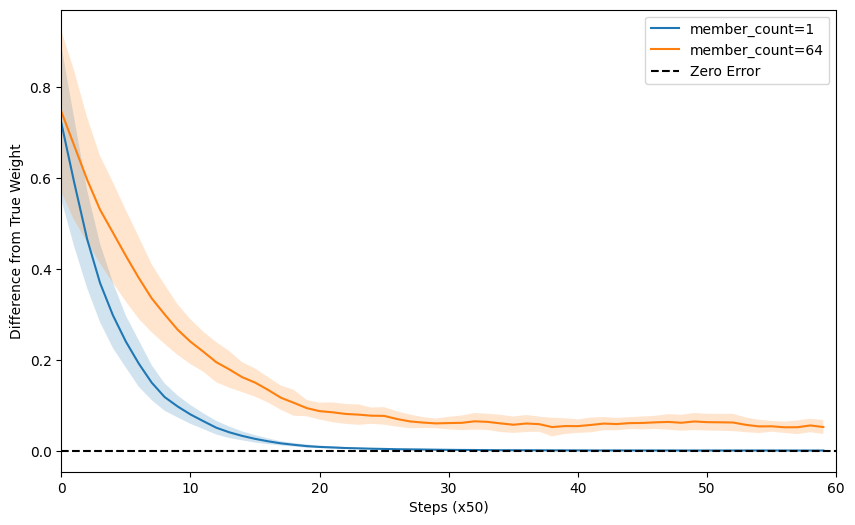

In [191]:
member_counts = [1, 64] # [4, 8, 16, 32, 64, 128, 256]
n_seeds = 10

# Store values for both plots
weight_estimates = {seed: {} for seed in range(n_seeds)}
weight_differences = {seed: {} for seed in range(n_seeds)}
avg_distances = {seed: {} for seed in range(n_seeds)}

x_bin_size = 50
train_steps = 3000
n_inputs = 10

for seed in range(n_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    for member_count in member_counts:
        results = run_ensemble_experiment(
            train_steps = train_steps,
            n_inputs = n_inputs,
            n_distractors = 90,
            member_dim = 32 if member_count > 1 else 100,
            init_lr = 2**-8 if member_count > 1 else 2**-7,
            n_models = member_count,
            return_real_feature_weights = True,
            seed = seed,
        )
        real_feature_weights = results['real_feature_weights']
        real_feature_weight_means = torch.stack([ws.mean(dim=1) for ws in real_feature_weights], dim=1)
        real_feature_weight_means = real_feature_weight_means.numpy() # dim: (train_steps, n_inputs)
        real_weights = results['true_weights'].squeeze(0).detach().cpu().numpy() # dim: (n_inputs)
        
        # Store mean weights and differences from true weight
        abs_weight_differences = np.abs(real_feature_weight_means - real_weights[None, :])
        weight_differences[seed][member_count] = abs_weight_differences.reshape(-1, x_bin_size, n_inputs).mean(1).mean(1)
        weight_estimates[seed][member_count] = real_feature_weight_means.reshape(-1, x_bin_size, n_inputs).mean(1)
        
        # Calculate average distance from true weight
        avg_distances[seed][member_count] = abs_weight_differences.mean(0)

# Plot differences from true weight with variance
plt.figure(figsize=(10, 6))
for member_count in member_counts:
    means = np.stack([weight_differences[seed][member_count] for seed in range(n_seeds)]).mean(0)
    stds = np.stack([weight_differences[seed][member_count] for seed in range(n_seeds)]).std(0)
    plt.plot(means, label=f'member_count={member_count}')
    plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2)
plt.axhline(y=0, color='black', linestyle='--', label='Zero Error')
plt.xlim(0, train_steps // x_bin_size)
plt.xlabel('Steps' + f' (x{x_bin_size})' if train_steps > 1 else '')
plt.ylabel('Difference from True Weight')
plt.legend()

# Print average distances with standard deviation and variance
print("\nStatistics for distance from true weight per step:")
for member_count in member_counts:
    values = np.array([avg_distances[seed][member_count].mean() for seed in range(n_seeds)])
    print(f"Member count {member_count}:")
    print(f"  Mean ± Std: {values.mean():.6f} ± {values.std():.6f}")
    print(f"  Variance: {values.var():.6f}")

## Variance when noise is added


Statistics for distance from true weight per step:
Member count 1:
  Mean ± Std: 0.646522 ± 0.147904
  Variance: 0.021876
Member count 128:
  Mean ± Std: 0.639139 ± 0.145809
  Variance: 0.021260


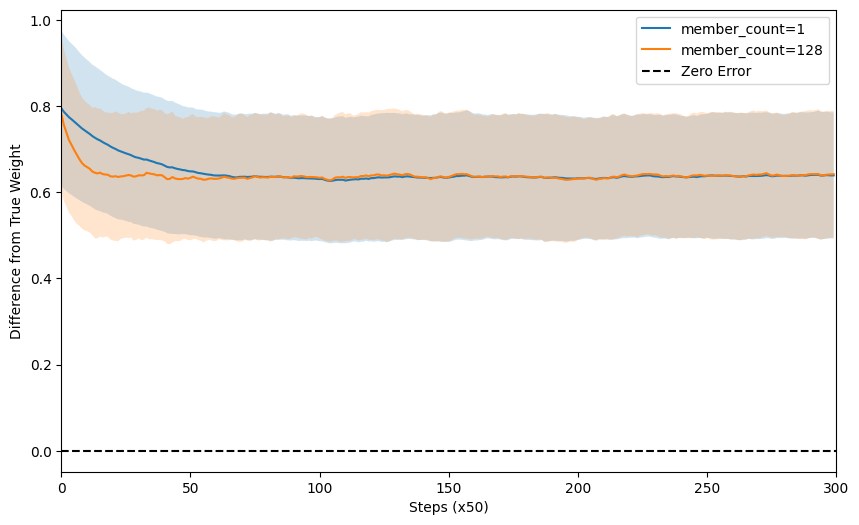

In [ ]:
# TODO: I think there is an error here because the weights are not converging to the optimal values
# Need to fix this

member_counts = [1, 128] # [4, 8, 16, 32, 64, 128, 256]
n_seeds = 10

# Store values for both plots
weight_estimates = {seed: {} for seed in range(n_seeds)}
weight_differences = {seed: {} for seed in range(n_seeds)}
avg_distances = {seed: {} for seed in range(n_seeds)}

x_bin_size = 50
train_steps = 15_000
n_inputs = 10

for seed in range(n_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    for member_count in member_counts:
        results = run_ensemble_experiment(
            train_steps = train_steps,
            n_inputs = n_inputs,
            n_distractors = 90,
            member_dim = 32 if member_count > 1 else 100,
            init_lr = 2**-10 if member_count > 1 else 2**-12,
            n_models = member_count,
            return_real_feature_weights = True,
            seed = seed,
            noise_strength = 1.0,
        )
        real_feature_weights = results['real_feature_weights']
        real_feature_weight_means = torch.stack([ws.mean(dim=1) for ws in real_feature_weights], dim=1)
        real_feature_weight_means = real_feature_weight_means.numpy() # dim: (train_steps, n_inputs)
        real_weights = results['true_weights'].squeeze(0).detach().cpu().numpy() # dim: (n_inputs)
        
        # Store mean weights and differences from true weight
        abs_weight_differences = np.abs(real_feature_weight_means - real_weights[None, :])
        weight_differences[seed][member_count] = abs_weight_differences.reshape(-1, x_bin_size, n_inputs).mean(1).mean(1)
        weight_estimates[seed][member_count] = real_feature_weight_means.reshape(-1, x_bin_size, n_inputs).mean(1)
        
        # Calculate average distance from true weight
        avg_distances[seed][member_count] = abs_weight_differences.mean(0)

# Plot differences from true weight with variance
plt.figure(figsize=(10, 6))
for member_count in member_counts:
    means = np.stack([weight_differences[seed][member_count] for seed in range(n_seeds)]).mean(0)
    stds = np.stack([weight_differences[seed][member_count] for seed in range(n_seeds)]).std(0)
    plt.plot(means, label=f'member_count={member_count}')
    plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2)
plt.axhline(y=0, color='black', linestyle='--', label='Zero Error')
plt.xlim(0, train_steps // x_bin_size)
plt.xlabel('Steps' + f' (x{x_bin_size})' if train_steps > 1 else '')
plt.ylabel('Difference from True Weight')
plt.legend()

# Print average distances with standard deviation and variance
print("\nStatistics for distance from true weight per step:")
for member_count in member_counts:
    values = np.array([avg_distances[seed][member_count].mean() for seed in range(n_seeds)])
    print(f"Member count {member_count}:")
    print(f"  Mean ± Std: {values.mean():.6f} ± {values.std():.6f}")
    print(f"  Variance: {values.var():.6f}")

In [ ]:
# TODO: Compare above results against training with all of the features at once

-0.08391580730676651

In [33]:
real_feature_value_means

tensor([ 0.0000,  0.0000, -0.0105,  ..., -0.0839, -0.0839, -0.0839])

In [16]:
features.shape

torch.Size([10, 21])

In [ ]:
seed = 20250813
device = torch.device('cuda')

torch.manual_seed(seed)
data_generator = torch.Generator(device=device).manual_seed(seed)

n_inputs = 20
noise_strength = 0.0
n_distractors = 10000
convergence_threshold = 0.01

true_weights = torch.randn(1, n_inputs, device=device)
model = torch.nn.Linear(n_inputs + n_distractors, 1, bias=False).to(device)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.005, init_lr=0.00001, autostep=True)

# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
    noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X[:n_inputs]
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step(predictions=y_pred)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= convergence_threshold:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

Number of steps: 16001
Loss: 0.01126911186945705


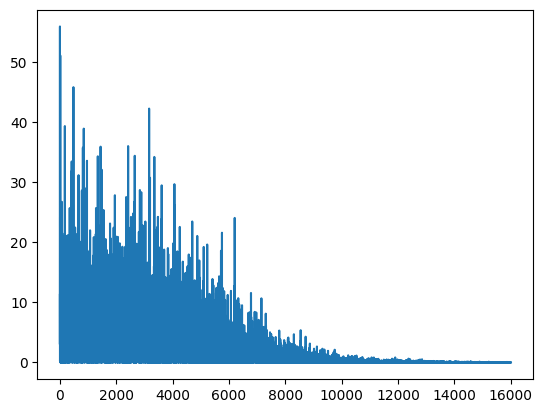

In [ ]:
seed = 20250813
device = torch.device('cuda')

torch.manual_seed(seed)
data_generator = torch.Generator(device=device).manual_seed(seed)

n_inputs = 20
noise_strength = 0.0
n_distractors = 10000
convergence_threshold = 0.01
n_models = 10

# TODO: Create a bunch of ensembles with different inputs.
# Plot the distance of the real features from their ideal weight values over time.
# Plot the L1 of the distrator weights over time, they should be closer to 0.
# Double check to make sure IDBD on multiple ensembles like this works.

true_weights = torch.randn(1, n_inputs, device=device)
model = ParallelLinear(n_inputs + n_distractors, 1, n_models, bias=False).to(device)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.005, init_lr=0.00001, autostep=True)

# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
    noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
    y_preds = model(noisy_X).squeeze(1)
    target = true_weights @ true_X[:n_inputs]
    individual_losses = (target.expand(n_models) - y_preds).pow(2)
    
    with torch.no_grad():
        mean_pred = y_preds.mean()
        pred_loss = (target - mean_pred).pow(2)
        losses.append(pred_loss.item())

    optimizer.zero_grad()
    individual_losses.sum().backward(retain_graph=True)
    optimizer.step(predictions=y_preds)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= convergence_threshold:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

In [16]:
# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs,), dtype=torch.float)
    noisy_X = true_X + torch.randn(n_inputs) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step(predictions=y_pred)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= 0:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)